In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import os
import sys
sys.path.append('../../utils')
import lec5_graphs as afx

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize']=(10, 6)

## Problema del SVM

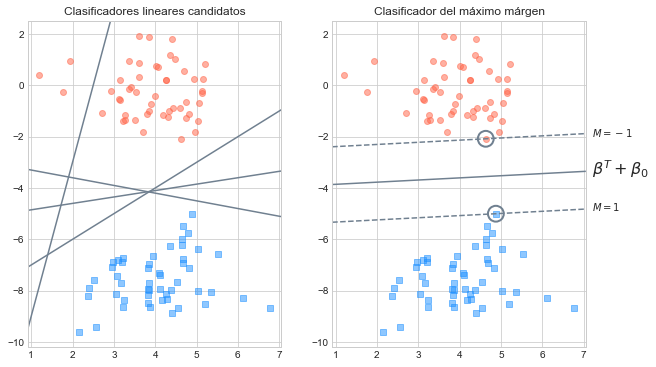

In [4]:
afx.setup_svm_problem()

## Casos No separables

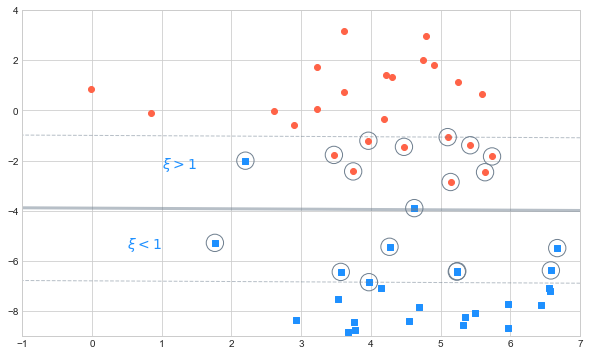

In [5]:
afx.svm_non_separable(plot_slacks=True, plot_xi=True)

## Ejemplo práctico

In [6]:
df = pd.read_csv('../../data/un3_winequality_merged.csv').drop(columns='Unnamed: 0')

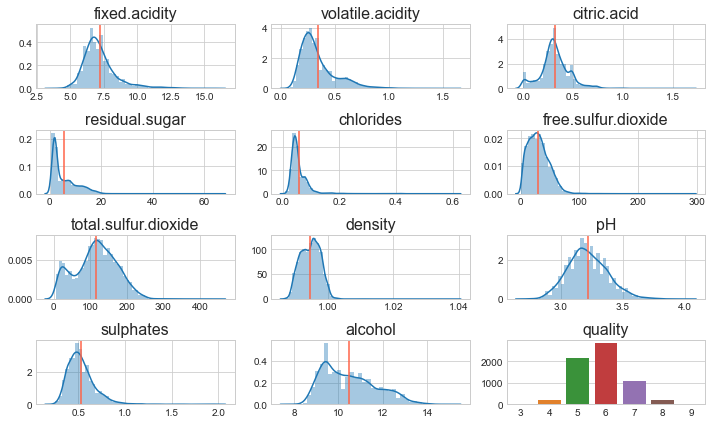

In [7]:
rows = 4; cols = df.shape[1] / rows
for index, (colname, serie) in enumerate(df.iteritems()):
    plt.subplot(rows, cols, index + 1)
    if pd.api.types.is_float_dtype(serie) is True:
        sns.distplot(serie)
        plt.axvline(np.mean(serie), color='tomato')
    elif pd.api.types.is_integer_dtype(serie) is True:
        sns.countplot(serie)
    plt.title(colname, fontsize=16)
    plt.xlabel('');plt.ylabel('');plt.tight_layout()

In [8]:
df['quality_bin'] = np.where(df['quality'] > np.mean(df['quality']), 1, 0)
df['quality_bin'].value_counts('%').round(3)

1    0.633
0    0.367
Name: quality_bin, dtype: float64

In [9]:
# Generamos las muestras de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'fixed.acidity':'alcohol'], df['quality_bin'], random_state=11238, test_size=.33)

# Generamos el pipeline
wine_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='linear'))
])

In [10]:
wine_svc.fit(X_train, y_train)
y_hat = wine_svc.predict(X_test)
print(classification_report(y_test, y_hat))
#afx.plot_class_report(y_test, y_hat, classes_labels=['Good', 'Bad'])

              precision    recall  f1-score   support

           0       0.70      0.56      0.62       815
           1       0.76      0.85      0.80      1330

    accuracy                           0.74      2145
   macro avg       0.73      0.71      0.71      2145
weighted avg       0.74      0.74      0.74      2145



## Probar con un nuevo kernel

Reexpresión de los datos

In [11]:
wine_svc_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf'))
])

wine_svc_rbf.fit(X_train, y_train)
y_hat = wine_svc_rbf.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67       815
           1       0.79      0.86      0.82      1330

    accuracy                           0.77      2145
   macro avg       0.76      0.74      0.74      2145
weighted avg       0.76      0.77      0.76      2145



## Hiperparametros

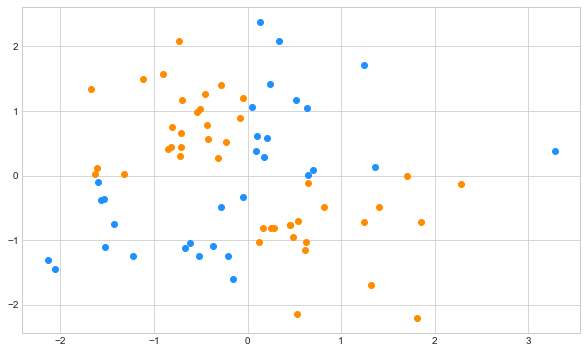

In [12]:
X, y = afx.svm_logical_xor_data(nsize=75)
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], color='darkorange')
plt.scatter(X[y==-1][:, 0], X[y==-1][:, 1], color='dodgerblue');

### C penalizacion

Si la C es más alta, la optimización elegirá un hiperplano de margen más pequeño, por lo que la tasa de clasificación de pérdida de datos de entrenamiento será más baja.

Por otro lado, si la C es baja, entonces el margen será grande, incluso si habrá ejemplos de datos de entrenamiento perdidos clasificados

![](cpen.png)

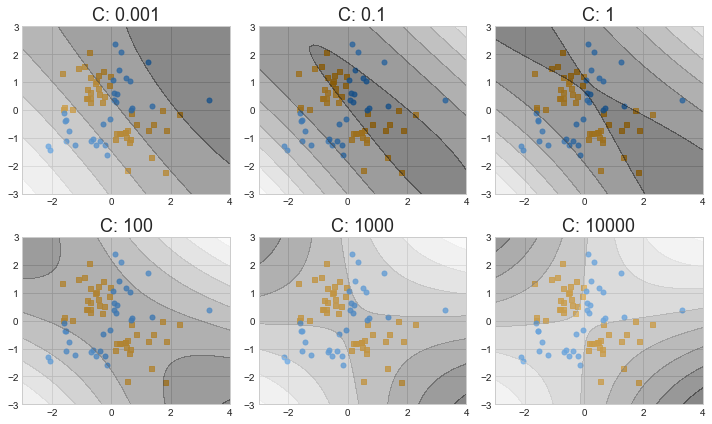

In [13]:
X, y = afx.svm_logical_xor_data(nsize=75)
afx.svm_c_hyperparameter(X, y, c_range=[0.001, 0.1, 1, 100, 1000, 10000])

### GAMMA

El parámetro gamma define hasta dónde llega la influencia de un solo ejemplo de entrenamiento. Esto significa que Gamma alto considerará solo puntos cercanos al hiperplano plausible y Gamma bajo considerará puntos a mayor distancia.

![](gamma.png)

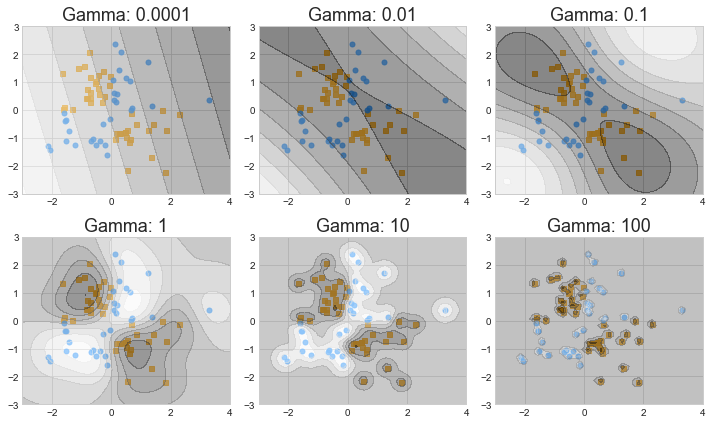

In [14]:
afx.svm_gamma_hyperparameter(X, y, gamma_range=[0.0001, 0.01,0.1, 1, 10, 100])

In [15]:
from sklearn.model_selection import cross_val_score

X_scaled = StandardScaler().fit_transform(df.loc[:, 'fixed.acidity':'alcohol'])
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    df['quality_bin'], random_state=11238, test_size=.33)

c_param_range = [1, 10, 100, 1000, 10000, 100000]
gamma_param_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

empty_dict = {}
best_score = 0
c_holder = []
for c in c_param_range:
    gamma_holder = []
    for gamma in gamma_param_range:
        tmp_score = cross_val_score(SVC(C=c, gamma=gamma), X_train, y_train, cv=5, n_jobs=-1)
        # SAVE
        empty_dict[str("C: {}, Gamma: {}".format(c, gamma))] = list(tmp_score)
        gamma_holder.append(np.mean(tmp_score))
        if np.mean(tmp_score) > best_score:
            best_score = np.mean(tmp_score)
            best_params = str("C: {}, Gamma: {}".format(c, gamma))
    c_holder.append(gamma_holder)
cv_params = np.array(c_holder).reshape(6, 6)

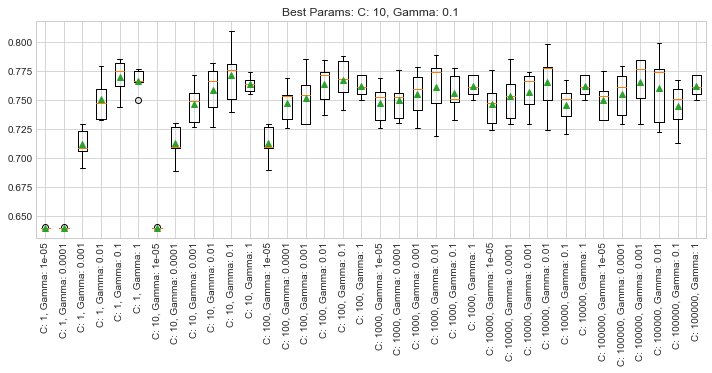

In [19]:
plt.figure(figsize=(12, 4))
plt.boxplot(empty_dict.values(), showmeans=True);
plt.xticks(range(1, len(empty_dict.keys()) + 1), empty_dict.keys(), rotation=90);
plt.title("Best Params: {}".format(best_params));

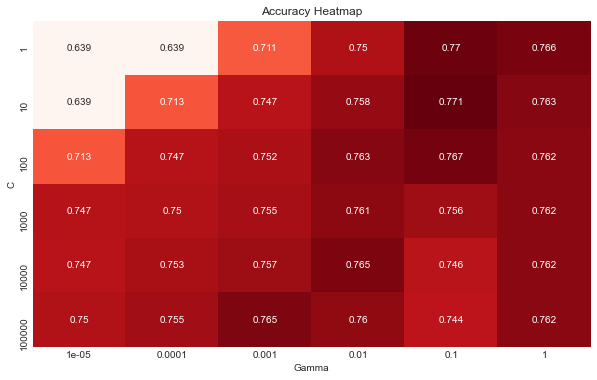

In [17]:
sns.heatmap(cv_params, annot=True, cmap='Reds', cbar=False, xticklabels=gamma_param_range,
yticklabels=c_param_range, fmt=".3")
plt.xlabel('Gamma');
plt.ylabel('C');
plt.title('Accuracy Heatmap');

## Testear fuera de la calibración

In [18]:
from sklearn.metrics import classification_report
refactor_svc_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', C=10, gamma=0.1))
])

refactor_svc_rbf.fit(X_train, y_train)
yhat = refactor_svc_rbf.predict(X_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70       815
           1       0.81      0.85      0.83      1330

    accuracy                           0.78      2145
   macro avg       0.77      0.76      0.76      2145
weighted avg       0.78      0.78      0.78      2145

